# Table of contents

### - Import libraries and define functions + Initial setup

### - Data pre-processing (Our Data)

### - Data pre-processing (GTEX Data)

### - Data pre-processing (Merge Data)

### - Make figures RegPlot (Relative Abundance)

### - Make figures RegPlot (Median CPM)

### - Make figures RegPlot (Total CPM)

### - Make figures DensityPlot (Relative Abundance)

### - Make figures DensityPlot (Median CPM)

### - Make figures DensityPlot (Total CPM)

### - Unique and full-length counts analysis

### - Save transcripts for validation

# Import libraries and define functions + Initial setup

In [1]:
## Import Libraries
import pandas as pd
import numpy as np
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud
import csv
from scipy import stats
from scipy.stats import gaussian_kde

## Display all rows of pandas dataframes
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [2]:
'''
name: relative_transcript_abundance

purpose: calculate relative transcript abundance

input: a dataframe with a ref_gene_id column identifying the transcript gene of origin and a cov columns with 
the coverage for the transcripts.

output: the same dataframe with a relative abundance column added
'''



def relative_transcript_abundance(df):
    
    dff = df.copy()
    
    ## Group by gene_id and get total expression for each gene (not counting introns)
    dff_sums = dff[["gene_id", "total_CPM"]].groupby("gene_id").sum()
    dff_sums["total_CPM_gene"] = dff_sums["total_CPM"]
    dff_sums.drop(columns="total_CPM", inplace=True)
    
    ## Merge dataframe with total gene level CPM with regular transcript level CPM dataframe
    merged_dff = pd.merge(dff, dff_sums, how='inner', on="gene_id")
    
    ## Calculater relative percent abundance for each transcript within its gene
    merged_dff["relative_abundance_percent"] = ((merged_dff["total_CPM"]/merged_dff["total_CPM_gene"]) * 100)
    
    ## Rename total_CPM for transcript column
    merged_dff["total_CPM_transcript"] = merged_dff["total_CPM"]
    merged_dff.drop(columns="total_CPM", inplace=True)
    
    merged_dff.fillna(value=0, inplace=True)


    return merged_dff

In [3]:
'''
function name: fix_column_names

purpose: Fixing the column names, making them smaller, informative, and consistent

input: The raw counts dataframe for either genes or transcripts 

output: Same dataframe with improved column names
'''

def fix_column_names(df, is_gene=False):
    
    
    dff = df.copy()
    
    ## Check if this is a gene counts object
    if is_gene:
        
        ## Get count column names and create list of new column names
        count_columns = dff.columns.tolist()
        list_new_names = ["gene_id"]
        
        ## gene_id comes in as index for gene counts data, make it into the first column instead
        dff["gene_id"] = dff.index
        cols = list(dff.columns)
        cols = [cols[-1]] + cols[:-1]
        dff = dff[cols]
        dff.reset_index(inplace=True, drop=True)
    
    ## If it is a transcript dataset
    else:
        ## Set count columns and create list of new names
        count_columns = dff.columns[2:].tolist()
        list_new_names = [ "transcript_id", "gene_id"]
    
    ## Fix names one by one and add to list of new names
    for col in count_columns:
        col = col.split("_mapped")[0] + "_counts"
        list_new_names.append(col)
    
    ## Rename columns
    dff.columns = list_new_names
    
    return dff 

In [4]:
'''
function name: parse_dff_columns

purpose: parsing the last aggregate column of the gtf/gff3 into useful columns and cleaning non-relevant columns

input: dataframe containining "raw" gtf/gff

output: dataframe containing gtf with useful columns ["gene_id", "transcript_id", etc...]
'''

def parse_df_columns(df, is_ref=True, is_transcript=False, is_prot=False, delete_other=True):

    dff = df.copy()
    
    if is_ref:

        ## Get gene ids
        dff["gene_id"] = dff["other"].str.split('";', expand=True)[0].str.extract("([^ \"]*$)", expand=True)
        
        ## Get gene names
        dff["gene_name"] = dff["other"].str.split("gene_name \"", expand=True)[1].str.split('\";', expand=True)[0]
        
        ## Get get transcript biotype
        dff["gene_biotype"] = dff["other"].str.split('gene_biotype "', expand=True)[1].str.split('"', expand=True)[0]
        
        ## If is transcript get transcript id and transcript biotype
        if is_transcript:
            dff["transcript_id"] = dff["other"].str.split('transcript_id "', expand=True)[1].str.split('"', expand=True)[0]
            dff["transcript_biotype"] = dff["other"].str.split('transcript_biotype "', expand=True)[1].str.split('"', expand=True)[0]
            
            ## If is prot get protein_id
            if is_prot:
                dff["protein_id"] = dff["other"].str.split('protein_id "', expand=True)[1].str.split('"', expand=True)[0]
                dff["ccds_id"] = dff["other"].str.split('ccds_id "', expand=True)[1].str.split('"', expand=True)[0]
                dff["exon_number"] = dff["other"].str.split('exon_number "', expand=True)[1].str.split('"', expand=True)[0]

        ## Drop "other" column
        dff.drop(columns=["other", "dot_1", "dot_2"], inplace=True)
        

    else:

        ## Get gene ids
        dff["gene_id"] = dff["other"].str.split('";', expand=True)[0].str.extract("([^ \"]*$)", expand=True)

        ## Get transcript ids
        dff["transcript_id"] = dff["other"].str.split('transcript_id "', expand=True)[1].str.split('"', expand=True)[0]

        ## Get exon number
        dff["exon_number"] = dff["other"].str.split('exon_number "', expand=True)[1].str.split('"', expand=True)[0]

        ## Drop "other" column
        if delete_other:
            dff.drop(columns=["other", "dot_1", "dot_2"], inplace=True)

    for col in dff.columns:
        dff.loc[dff[col].isnull(), col] = np.NaN
        

    return dff

In [5]:
'''
function name: calculate_cpm

purpose: Calculate CPM for the each sample given

input: Counts dataset

output: Counts dataset with CPM columns as well
'''

def calculate_cpm(df, is_gene=False):

    dff = df.copy()
    
    ## Set count columns if dataframe is gene counts
    if is_gene:
        count_columns = dff.columns[1:].tolist()
    
    ## Set count columns if dataframe is transcript counts
    else:
        count_columns = dff.columns[2:].tolist()

    ## Loop through counts columns to calculate CPM and add to the dataframe
    for col in count_columns:
        
        dff[col] = round(dff[col], 2)
        cpm_name = col.replace("_counts", "_CPM")
        dff[cpm_name] = round(((dff[col]/(dff[col].sum())) * 1000000), 2)
    
    return dff  

In [6]:
## define ggplot colors
ggplot2_colors = ["#F8766D", "#CD9600", "#7CAE00", "#00BE67", "#00BFC4", "#00A9FF", "#C77CFF", "#FF61CC"]

In [7]:
## Import and parse through extended annotations
ref = pd.read_csv("../../data/raw/nextflow_pipeline_output/bambu_discovery/extended_annotations.gtf", header=None, delimiter="\t",
                        low_memory=False, comment="#", names=["chr", "source", "type", "start", "end", "dot_1", "strand", "dot_2", "other"])

ref = ref.loc[~ref["chr"].str.startswith("ERCC-")]

ref = parse_df_columns(ref, is_ref=False)

ref_transcripts = ref.loc[ref["type"] == "transcript"].copy()

# - Data pre-processing (Our Data)

In [8]:
## Import data for transcript level counts and fix column names

df_ours = pd.read_csv("../../data/raw/nextflow_pipeline_output/bambu_discovery/counts_transcript.txt", 
                           delimiter="\t", low_memory=False, header=0)

df_ours = fix_column_names(df_ours, is_gene=False)

In [9]:
## Calculate total counts
df_ours["total_counts"] = df_ours[df_ours.filter(regex='count').columns].sum(axis=1)

In [10]:
## Calculate CPM and drop count columns
df_ours = calculate_cpm(df_ours, is_gene=False)

df_ours = df_ours[df_ours.columns.drop(list(df_ours.filter(regex='counts')))].copy()

In [11]:
## Drop ERCCs
df_ours = df_ours.loc[~df_ours["gene_id"].str.startswith("ERCC")].copy()

In [12]:
## Calculate median CPM
df_ours["median_CPM"] = df_ours[df_ours.filter(regex='[0-9]_CPM').columns].median(axis=1)

In [13]:
## Annotate transcritps in counts matrix
df_ours = df_ours.merge(ref_transcripts[["gene_id", "transcript_id", "chr"]], on=["gene_id", "transcript_id"], how="inner")

In [14]:
## Add relative transcript abundance to dataframe
df_ours = relative_transcript_abundance(df_ours)

In [15]:
## Only keep genes and transcripts with median CPM > 1
df_ours = df_ours.loc[df_ours["median_CPM"] > 1].copy()

In [16]:
## Only keep high confidence mitochondrial transcripts
df_ours_mito_high = df_ours.loc[df_ours["transcript_id"].isin(["BambuTx1845", "BambuTx1846", "BambuTx1847", "BambuTx1848", 
                                                "BambuTx1850"])].copy()

df_ours = df_ours.loc[~((df_ours["chr"] == "MT") & (df_ours["transcript_id"].str.startswith("BambuTx")))].copy()

df_ours = pd.concat([df_ours, df_ours_mito_high])

In [17]:
## Only keep relevant columns
df_ours = df_ours[["transcript_id", "gene_id", "chr", "median_CPM",
                   "total_CPM_gene", "total_CPM_transcript", "relative_abundance_percent"]].copy()

## Rename columns to indicate they are from our data
df_ours.columns = ["transcript_id", "gene_id", "chr", "median_CPM_OURS",
                   "total_CPM_gene_OURS", "total_CPM_transcript_OURS", "relative_abundance_percent_OURS"]

## Add log + 1 columns
df_ours["log_plus1_total_CPM_transcript_OURS"] = np.log2((df_ours['total_CPM_transcript_OURS'] + 1))
df_ours["log_plus1_median_CPM_OURS"] = np.log2((df_ours['median_CPM_OURS'] + 1))

In [18]:
## Separate dataframe in three (known, new_from_known, new_from_new)
df_ours_known = df_ours.loc[~(df_ours["transcript_id"].str.startswith("Bambu"))].copy()

df_ours_new_from_known = df_ours.loc[((df_ours["transcript_id"].str.startswith("Bambu")) & 
                                ~(df_ours["gene_id"].str.startswith("Bambu")))].copy()

df_ours_new_from_new = df_ours.loc[((df_ours["transcript_id"].str.startswith("Bambu")) & 
                                (df_ours["gene_id"].str.startswith("Bambu")))].copy()

# - Data pre-processing (GTEX BA9 data)

In [19]:
## Import data for transcript level counts and fix column names

df_gtex = pd.read_csv("../../data/raw/rebuttal_data/GTEX_with_our_extended_annotation_quant/bambu_quant/counts_transcript.txt", 
                           delimiter="\t", low_memory=False, header=0)

## Only keep BA9 brain samples
## Excluded BA9 sample "GTEX-T5JC-0011-R10A-SM-2TT23.FAK91589" because it had only 46331 reads.
df_gtex = df_gtex[["TXNAME", "GENEID","GTEX-1192X-0011-R10a-SM-4RXXZ.FAK49046_mapped_filtered_sorted",
                  "GTEX-13X6J-0011-R10b-SM-5CEKT.FAK44896_mapped_filtered_sorted",
                  "GTEX-14BIL-0011-R10a-SM-5EQV4.FAK49209_mapped_filtered_sorted",
                  "GTEX-QDT8-0011-R10A-SM-2FKJB.FAK49182_mapped_filtered_sorted"]]

df_gtex = fix_column_names(df_gtex, is_gene=False)

In [20]:
## Calculate total counts
df_gtex["total_counts"] = df_gtex[df_gtex.filter(regex='count').columns].sum(axis=1)

In [21]:
## Calculate CPM and drop count columns
df_gtex = calculate_cpm(df_gtex, is_gene=False)

df_gtex = df_gtex[df_gtex.columns.drop(list(df_gtex.filter(regex='counts')))].copy()

In [22]:
## Drop ERCCs
df_gtex = df_gtex.loc[~df_gtex["gene_id"].str.startswith("ERCC")].copy()

In [23]:
## Calculate median CPM
df_gtex["median_CPM"] = df_gtex[df_gtex.filter(regex='[0-9]_CPM').columns].median(axis=1)

In [24]:
## Annotate transcritps in counts matrix
df_gtex = df_gtex.merge(ref_transcripts[["gene_id", "transcript_id", "chr"]], on=["gene_id", "transcript_id"], how="inner")

In [25]:
## Add relative transcript abundance to dataframe
df_gtex = relative_transcript_abundance(df_gtex)

In [26]:
## Only keep relevant columns
df_gtex = df_gtex[["transcript_id", "gene_id", "chr", "median_CPM",
                   "total_CPM_gene", "total_CPM_transcript", "relative_abundance_percent"]].copy()

## Rename columns to indicate they are from our data
df_gtex.columns = ["transcript_id", "gene_id", "chr", "median_CPM_GTEX",
                   "total_CPM_gene_GTEX", "total_CPM_transcript_GTEX", "relative_abundance_percent_GTEX"]

## Add log + 1 columns
df_gtex["log_plus1_total_CPM_transcript_GTEX"] = np.log2((df_gtex['total_CPM_transcript_GTEX'] + 1))
df_gtex["log_plus1_median_CPM_GTEX"] = np.log2((df_gtex['median_CPM_GTEX'] + 1))


# - Merge ours and GTEX data

In [27]:
df_known = df_ours_known.merge(df_gtex, on=["transcript_id", "gene_id", "chr"], how="inner")

df_new_from_known = df_ours_new_from_known.merge(df_gtex, on=["transcript_id", "gene_id", "chr"], how="inner")

df_new_from_new = df_ours_new_from_new.merge(df_gtex, on=["transcript_id", "gene_id", "chr"], how="inner")

# - Make figures RegPlot (Relative Abundance)

Spearman coefficient: 0.78
Spearman R-squared: 0.61
Spearman p-value: 0.0

Pearson coefficient: 0.81
Pearson R-squared: 0.65
Pearson Slope: 0.75
Pearson Intercept: 16.01
Pearson P-value: 0.0
Pearson Standard Error: 0.0033 



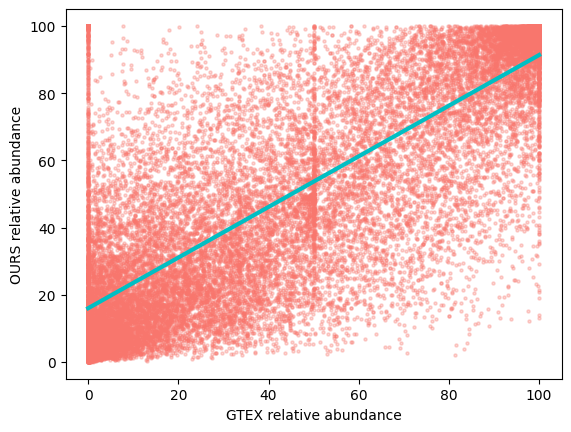

In [28]:
sns.regplot(data=df_known, x="relative_abundance_percent_GTEX", y="relative_abundance_percent_OURS", color=ggplot2_colors[0], 
           scatter_kws={"alpha": 0.3, "s":5}, line_kws={"linewidth": 3, "color": ggplot2_colors[4]})

plt.xlabel("GTEX relative abundance")
plt.ylabel("OURS relative abundance")

spearman_coeff, spearman_p = stats.spearmanr(df_known["relative_abundance_percent_GTEX"].copy(),
                                                                     df_known["relative_abundance_percent_OURS"].copy())

slope, intercept, r_value, p_value, std_err = stats.linregress(df_known["relative_abundance_percent_GTEX"].copy(),
                                                                     df_known["relative_abundance_percent_OURS"].copy())

print("Spearman coefficient:", str(round(spearman_coeff, 2)))
print("Spearman R-squared:", str(round((spearman_coeff * spearman_coeff), 2)))
print("Spearman p-value:", str(spearman_p))

print("\nPearson coefficient:", str(round(r_value, 2)))
print("Pearson R-squared:", str(round(r_value*r_value,2)))
print("Pearson Slope:", str(round(slope,2)))
print("Pearson Intercept:", str(round(intercept,2)))
print("Pearson P-value:", str(p_value))
print("Pearson Standard Error:", str(round(std_err,4)), "\n")

plt.savefig('../../figures/ours_vs_gtex/known_transcripts_median_CPM_1_OURS_vs_GTEX_relative_abundance.pdf',
            dpi=600, transparent=True, bbox_inches="tight")



Spearman coefficient: 0.75
Spearman R-squared: 0.56
Spearman p-value: 1.5617117893495744e-78

Pearson coefficient: 0.8
Pearson R-squared: 0.63
Pearson Slope: 0.71
Pearson Intercept: 10.47
Pearson P-value: 3.131787793725501e-96
Pearson Standard Error: 0.026 



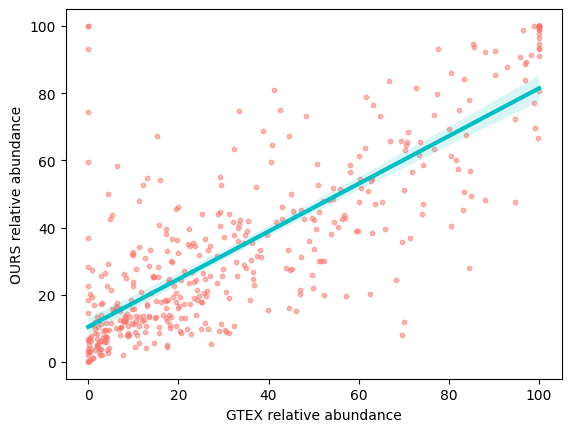

In [29]:
sns.regplot(data=df_new_from_known, x="relative_abundance_percent_GTEX", y="relative_abundance_percent_OURS", color=ggplot2_colors[0], 
           scatter_kws={"alpha": 0.5, "s":10}, line_kws={"linewidth": 3, "color": ggplot2_colors[4]})

plt.xlabel("GTEX relative abundance")
plt.ylabel("OURS relative abundance")

spearman_coeff, spearman_p = stats.spearmanr(df_new_from_known["relative_abundance_percent_GTEX"].copy(),
                                                                     df_new_from_known["relative_abundance_percent_OURS"].copy())

slope, intercept, r_value, p_value, std_err = stats.linregress(df_new_from_known["relative_abundance_percent_GTEX"].copy(),
                                                                     df_new_from_known["relative_abundance_percent_OURS"].copy())

print("Spearman coefficient:", str(round(spearman_coeff, 2)))
print("Spearman R-squared:", str(round((spearman_coeff * spearman_coeff), 2)))
print("Spearman p-value:", str(spearman_p))

print("\nPearson coefficient:", str(round(r_value, 2)))
print("Pearson R-squared:", str(round(r_value*r_value,2)))
print("Pearson Slope:", str(round(slope,2)))
print("Pearson Intercept:", str(round(intercept,2)))
print("Pearson P-value:", str(p_value))
print("Pearson Standard Error:", str(round(std_err,4)), "\n")

plt.savefig('../../figures/ours_vs_gtex/new_from_known_transcripts_median_CPM_1_OURS_vs_GTEX_relative_abundance.pdf',
            dpi=600, transparent=True, bbox_inches="tight")

Spearman coefficient: -0.06
Spearman R-squared: 0.0
Spearman p-value: 0.3511012709211193

Pearson coefficient: 0.1
Pearson R-squared: 0.01
Pearson Slope: 0.05
Pearson Intercept: 87.38
Pearson P-value: 0.11950182266560877
Pearson Standard Error: 0.0314 



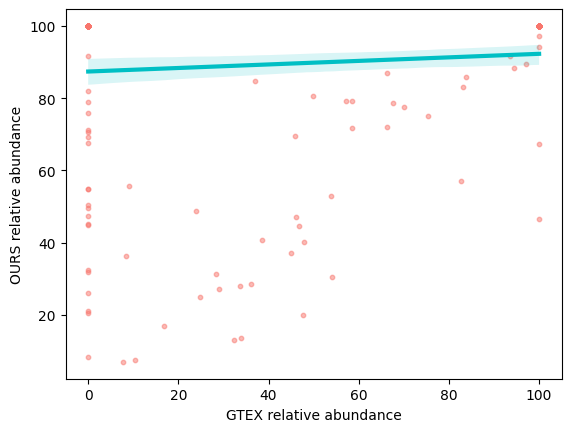

In [30]:
sns.regplot(data=df_new_from_new, x="relative_abundance_percent_GTEX", y="relative_abundance_percent_OURS", color=ggplot2_colors[0], 
           scatter_kws={"alpha": 0.5, "s":10}, line_kws={"linewidth": 3, "color": ggplot2_colors[4]})

plt.xlabel("GTEX relative abundance")
plt.ylabel("OURS relative abundance")

spearman_coeff, spearman_p = stats.spearmanr(df_new_from_new["relative_abundance_percent_GTEX"].copy(),
                                                                     df_new_from_new["relative_abundance_percent_OURS"].copy())

slope, intercept, r_value, p_value, std_err = stats.linregress(df_new_from_new["relative_abundance_percent_GTEX"].copy(),
                                                                     df_new_from_new["relative_abundance_percent_OURS"].copy())

print("Spearman coefficient:", str(round(spearman_coeff, 2)))
print("Spearman R-squared:", str(round((spearman_coeff * spearman_coeff), 2)))
print("Spearman p-value:", str(spearman_p))

print("\nPearson coefficient:", str(round(r_value, 2)))
print("Pearson R-squared:", str(round(r_value*r_value,2)))
print("Pearson Slope:", str(round(slope,2)))
print("Pearson Intercept:", str(round(intercept,2)))
print("Pearson P-value:", str(p_value))
print("Pearson Standard Error:", str(round(std_err,4)), "\n")

plt.savefig('../../figures/ours_vs_gtex/new_from_new_transcripts_median_CPM_1_OURS_vs_GTEX_relative_abundance.pdf',
            dpi=600, transparent=True, bbox_inches="tight")


# - Make figures RegPlot (median CPM)

Spearman coefficient: 0.69
Spearman R-squared: 0.48
Spearman p-value: 0.0

Pearson coefficient: 0.76
Pearson R-squared: 0.57
Pearson Slope: 0.62
Pearson Intercept: 1.48
Pearson P-value: 0.0
Pearson Standard Error: 0.0032 



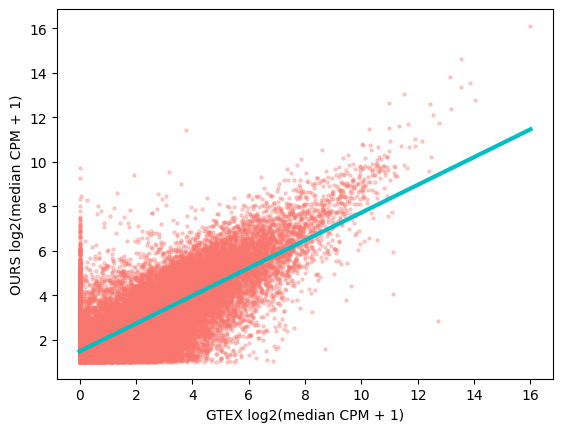

In [31]:
sns.regplot(data=df_known, x="log_plus1_median_CPM_GTEX", y="log_plus1_median_CPM_OURS", color=ggplot2_colors[0], 
           scatter_kws={"alpha": 0.3, "s":5}, line_kws={"linewidth": 3, "color": ggplot2_colors[4]})

plt.xlabel("GTEX log2(median CPM + 1)")
plt.ylabel("OURS log2(median CPM + 1)")

spearman_coeff, spearman_p = stats.spearmanr(df_known["log_plus1_median_CPM_GTEX"].copy(),
                                                                     df_known["log_plus1_median_CPM_OURS"].copy())

slope, intercept, r_value, p_value, std_err = stats.linregress(df_known["log_plus1_median_CPM_GTEX"].copy(),
                                                                     df_known["log_plus1_median_CPM_OURS"].copy())

print("Spearman coefficient:", str(round(spearman_coeff, 2)))
print("Spearman R-squared:", str(round((spearman_coeff * spearman_coeff), 2)))
print("Spearman p-value:", str(spearman_p))

print("\nPearson coefficient:", str(round(r_value, 2)))
print("Pearson R-squared:", str(round(r_value*r_value,2)))
print("Pearson Slope:", str(round(slope,2)))
print("Pearson Intercept:", str(round(intercept,2)))
print("Pearson P-value:", str(p_value))
print("Pearson Standard Error:", str(round(std_err,4)), "\n")

plt.savefig('../../figures/ours_vs_gtex/known_transcripts_median_CPM_1_OURS_vs_GTEX_log_plus1_median_CPM.pdf',
            dpi=600, transparent=True, bbox_inches="tight")

Spearman coefficient: 0.47
Spearman R-squared: 0.23
Spearman p-value: 9.712361592821245e-26

Pearson coefficient: 0.66
Pearson R-squared: 0.43
Pearson Slope: 0.51
Pearson Intercept: 1.01
Pearson P-value: 7.090091171363769e-55
Pearson Standard Error: 0.028 



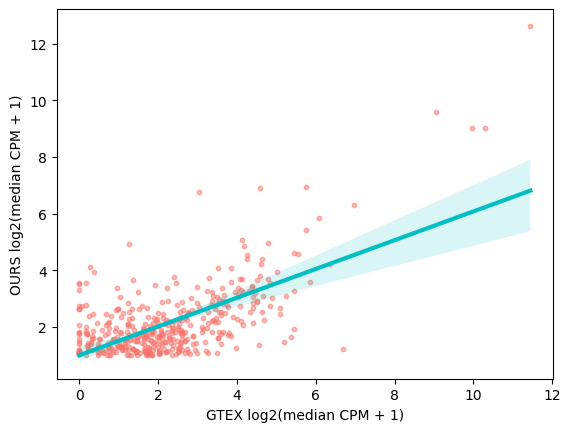

In [32]:
sns.regplot(data=df_new_from_known, x="log_plus1_median_CPM_GTEX", y="log_plus1_median_CPM_OURS", color=ggplot2_colors[0], 
           scatter_kws={"alpha": 0.5, "s":10}, line_kws={"linewidth": 3, "color": ggplot2_colors[4]})

plt.xlabel("GTEX log2(median CPM + 1)")
plt.ylabel("OURS log2(median CPM + 1)")

spearman_coeff, spearman_p = stats.spearmanr(df_new_from_known["log_plus1_median_CPM_GTEX"].copy(),
                                                                     df_new_from_known["log_plus1_median_CPM_OURS"].copy())

slope, intercept, r_value, p_value, std_err = stats.linregress(df_new_from_known["log_plus1_median_CPM_GTEX"].copy(),
                                                                     df_new_from_known["log_plus1_median_CPM_OURS"].copy())

print("Spearman coefficient:", str(round(spearman_coeff, 2)))
print("Spearman R-squared:", str(round((spearman_coeff * spearman_coeff), 2)))
print("Spearman p-value:", str(spearman_p))

print("\nPearson coefficient:", str(round(r_value, 2)))
print("Pearson R-squared:", str(round(r_value*r_value,2)))
print("Pearson Slope:", str(round(slope,2)))
print("Pearson Intercept:", str(round(intercept,2)))
print("Pearson P-value:", str(p_value))
print("Pearson Standard Error:", str(round(std_err,4)), "\n")

plt.savefig('../../figures/ours_vs_gtex/new_from_known_transcripts_median_CPM_1_OURS_vs_GTEX_log_plus1_median_CPM.pdf',
            dpi=600, transparent=True, bbox_inches="tight")

Spearman coefficient: 0.08
Spearman R-squared: 0.01
Spearman p-value: 0.17702286699641073

Pearson coefficient: 0.26
Pearson R-squared: 0.07
Pearson Slope: 0.21
Pearson Intercept: 1.6
Pearson P-value: 2.3617342783100964e-05
Pearson Standard Error: 0.0497 



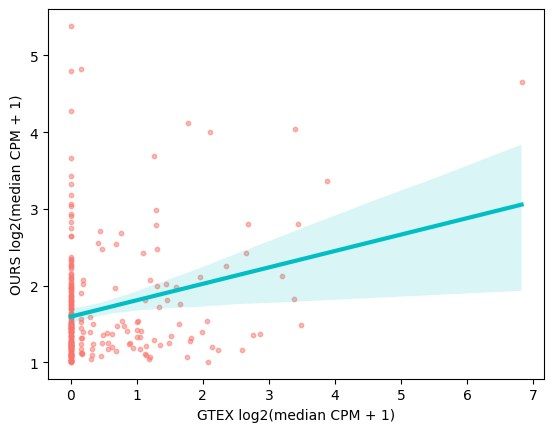

In [33]:
sns.regplot(data=df_new_from_new, x="log_plus1_median_CPM_GTEX", y="log_plus1_median_CPM_OURS", color=ggplot2_colors[0], 
           scatter_kws={"alpha": 0.5, "s":10}, line_kws={"linewidth": 3, "color": ggplot2_colors[4]})

plt.xlabel("GTEX log2(median CPM + 1)")
plt.ylabel("OURS log2(median CPM + 1)")

spearman_coeff, spearman_p = stats.spearmanr(df_new_from_new["log_plus1_median_CPM_GTEX"].copy(),
                                                                     df_new_from_new["log_plus1_median_CPM_OURS"].copy())

slope, intercept, r_value, p_value, std_err = stats.linregress(df_new_from_new["log_plus1_median_CPM_GTEX"].copy(),
                                                                     df_new_from_new["log_plus1_median_CPM_OURS"].copy())

print("Spearman coefficient:", str(round(spearman_coeff, 2)))
print("Spearman R-squared:", str(round((spearman_coeff * spearman_coeff), 2)))
print("Spearman p-value:", str(spearman_p))

print("\nPearson coefficient:", str(round(r_value, 2)))
print("Pearson R-squared:", str(round(r_value*r_value,2)))
print("Pearson Slope:", str(round(slope,2)))
print("Pearson Intercept:", str(round(intercept,2)))
print("Pearson P-value:", str(p_value))
print("Pearson Standard Error:", str(round(std_err,4)), "\n")

plt.savefig('../../figures/ours_vs_gtex/new_from_new_transcripts_median_CPM_1_OURS_vs_GTEX_log_plus1_median_CPM.pdf',
            dpi=600, transparent=True, bbox_inches="tight")

# - Make figures RegPlot (total CPM)

Spearman coefficient: 0.71
Spearman R-squared: 0.5
Spearman p-value: 0.0

Pearson coefficient: 0.77
Pearson R-squared: 0.59
Pearson Slope: 0.63
Pearson Intercept: 1.59
Pearson P-value: 0.0
Pearson Standard Error: 0.0031 



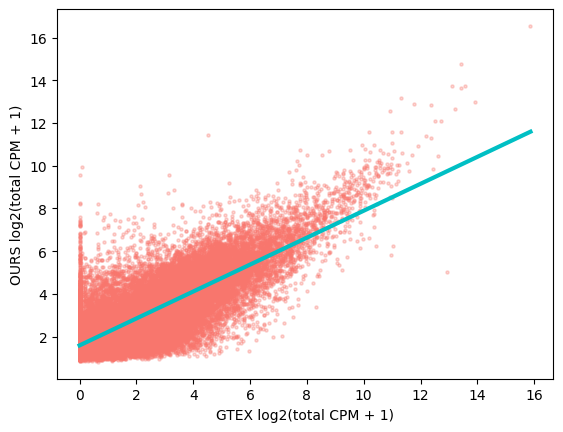

In [34]:
sns.regplot(data=df_known, x="log_plus1_total_CPM_transcript_GTEX", y="log_plus1_total_CPM_transcript_OURS", color=ggplot2_colors[0], 
           scatter_kws={"alpha": 0.3, "s":5}, line_kws={"linewidth": 3, "color": ggplot2_colors[4]})

plt.xlabel("GTEX log2(total CPM + 1)")
plt.ylabel("OURS log2(total CPM + 1)")

spearman_coeff, spearman_p = stats.spearmanr(df_known["log_plus1_total_CPM_transcript_GTEX"].copy(),
                                                                     df_known["log_plus1_total_CPM_transcript_OURS"].copy())

slope, intercept, r_value, p_value, std_err = stats.linregress(df_known["log_plus1_total_CPM_transcript_GTEX"].copy(),
                                                                     df_known["log_plus1_total_CPM_transcript_OURS"].copy())

print("Spearman coefficient:", str(round(spearman_coeff, 2)))
print("Spearman R-squared:", str(round((spearman_coeff * spearman_coeff), 2)))
print("Spearman p-value:", str(spearman_p))

print("\nPearson coefficient:", str(round(r_value, 2)))
print("Pearson R-squared:", str(round(r_value*r_value,2)))
print("Pearson Slope:", str(round(slope,2)))
print("Pearson Intercept:", str(round(intercept,2)))
print("Pearson P-value:", str(p_value))
print("Pearson Standard Error:", str(round(std_err,4)), "\n")

plt.savefig('../../figures/ours_vs_gtex/known_transcripts_median_CPM_1_OURS_vs_GTEX_total_CPM.pdf',
            dpi=600, transparent=True, bbox_inches="tight")

Spearman coefficient: 0.49
Spearman R-squared: 0.24
Spearman p-value: 2.512981197371345e-27

Pearson coefficient: 0.66
Pearson R-squared: 0.43
Pearson Slope: 0.53
Pearson Intercept: 1.17
Pearson P-value: 3.468621818031769e-55
Pearson Standard Error: 0.0293 



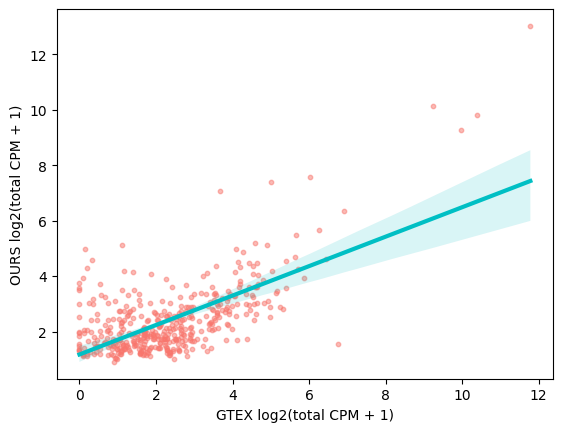

In [35]:
sns.regplot(data=df_new_from_known, x="log_plus1_total_CPM_transcript_GTEX", y="log_plus1_total_CPM_transcript_OURS", color=ggplot2_colors[0], 
           scatter_kws={"alpha": 0.5, "s":10}, line_kws={"linewidth": 3, "color": ggplot2_colors[4]})

plt.xlabel("GTEX log2(total CPM + 1)")
plt.ylabel("OURS log2(total CPM + 1)")

spearman_coeff, spearman_p = stats.spearmanr(df_new_from_known["log_plus1_total_CPM_transcript_GTEX"].copy(),
                                                                     df_new_from_known["log_plus1_total_CPM_transcript_OURS"].copy())

slope, intercept, r_value, p_value, std_err = stats.linregress(df_new_from_known["log_plus1_total_CPM_transcript_GTEX"].copy(),
                                                                     df_new_from_known["log_plus1_total_CPM_transcript_OURS"].copy())

print("Spearman coefficient:", str(round(spearman_coeff, 2)))
print("Spearman R-squared:", str(round((spearman_coeff * spearman_coeff), 2)))
print("Spearman p-value:", str(spearman_p))

print("\nPearson coefficient:", str(round(r_value, 2)))
print("Pearson R-squared:", str(round(r_value*r_value,2)))
print("Pearson Slope:", str(round(slope,2)))
print("Pearson Intercept:", str(round(intercept,2)))
print("Pearson P-value:", str(p_value))
print("Pearson Standard Error:", str(round(std_err,4)), "\n")

plt.savefig('../../figures/ours_vs_gtex/new_from_known_transcripts_median_CPM_1_OURS_vs_GTEX_total_CPM.pdf',
            dpi=600, transparent=True, bbox_inches="tight")

Spearman coefficient: 0.08
Spearman R-squared: 0.01
Spearman p-value: 0.21514456907123822

Pearson coefficient: 0.24
Pearson R-squared: 0.06
Pearson Slope: 0.2
Pearson Intercept: 1.77
Pearson P-value: 0.00010471684306839104
Pearson Standard Error: 0.0502 



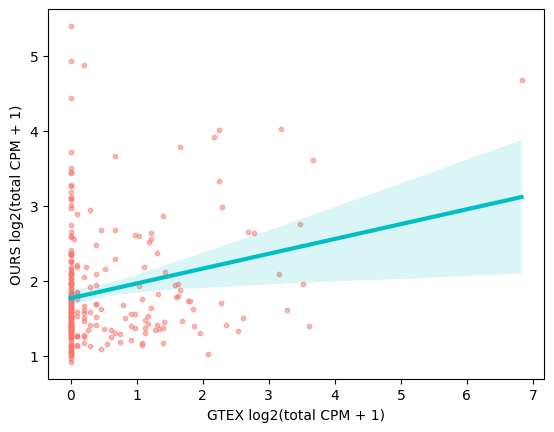

In [36]:
sns.regplot(data=df_new_from_new, x="log_plus1_total_CPM_transcript_GTEX", y="log_plus1_total_CPM_transcript_OURS", color=ggplot2_colors[0], 
           scatter_kws={"alpha": 0.5, "s":10}, line_kws={"linewidth": 3, "color": ggplot2_colors[4]})

plt.xlabel("GTEX log2(total CPM + 1)")
plt.ylabel("OURS log2(total CPM + 1)")

spearman_coeff, spearman_p = stats.spearmanr(df_new_from_new["log_plus1_total_CPM_transcript_GTEX"].copy(),
                                                                     df_new_from_new["log_plus1_total_CPM_transcript_OURS"].copy())

slope, intercept, r_value, p_value, std_err = stats.linregress(df_new_from_new["log_plus1_total_CPM_transcript_GTEX"].copy(),
                                                                     df_new_from_new["log_plus1_total_CPM_transcript_OURS"].copy())

print("Spearman coefficient:", str(round(spearman_coeff, 2)))
print("Spearman R-squared:", str(round((spearman_coeff * spearman_coeff), 2)))
print("Spearman p-value:", str(spearman_p))

print("\nPearson coefficient:", str(round(r_value, 2)))
print("Pearson R-squared:", str(round(r_value*r_value,2)))
print("Pearson Slope:", str(round(slope,2)))
print("Pearson Intercept:", str(round(intercept,2)))
print("Pearson P-value:", str(p_value))
print("Pearson Standard Error:", str(round(std_err,4)), "\n")

plt.savefig('../../figures/ours_vs_gtex/new_from_new_transcripts_median_CPM_1_OURS_vs_GTEX_total_CPM.pdf',
            dpi=600, transparent=True, bbox_inches="tight")

## - Make Figures DensityPlot (Relative Abundance)

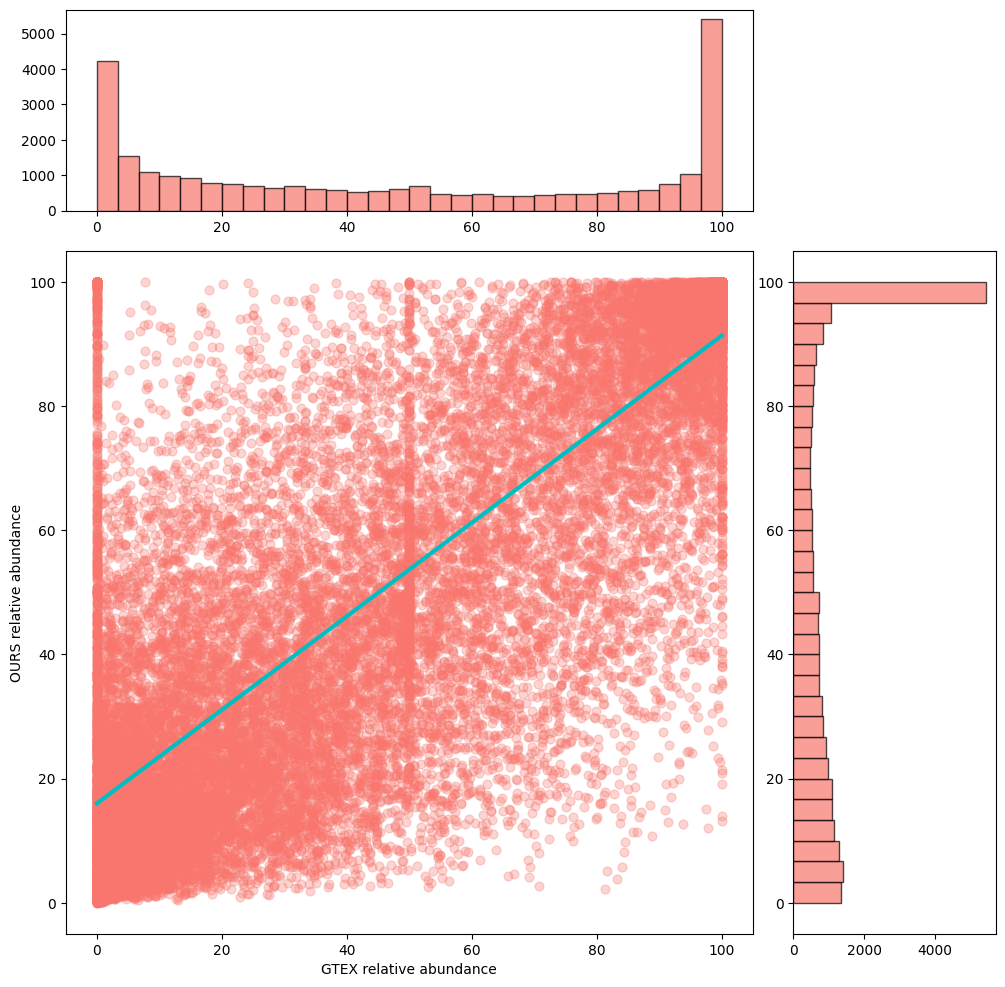

In [37]:
# Create a Seaborn jointplot with KDE (Kernel Density Estimation)
x = df_known["relative_abundance_percent_GTEX"].copy()
y= df_known["relative_abundance_percent_OURS"].copy()

# Create the main figure and axes
fig = plt.figure(figsize=(12, 12))
gs = plt.GridSpec(4, 4)

ax_main = fig.add_subplot(gs[1:4, 0:3])
ax_xDist = fig.add_subplot(gs[0, 0:3], sharex=ax_main)
ax_yDist = fig.add_subplot(gs[1:4, 3], sharey=ax_main)

# Scatter plot on main axes
sns.regplot(x=x, y=y, color=ggplot2_colors[0], 
           scatter_kws={"alpha": 0.3, "s":40}, line_kws={"linewidth": 3, "color": ggplot2_colors[4]}, ax=ax_main)

# Histogram on the attached axes
ax_xDist.hist(x, bins=30, edgecolor='k', color=ggplot2_colors[0], alpha=0.7)
ax_yDist.hist(y, bins=30, edgecolor='k', color=ggplot2_colors[0], alpha=0.7, orientation='horizontal')


# Show main axis labels
ax_main.set_xlabel("GTEX relative abundance")
ax_main.set_ylabel("OURS relative abundance")

plt.savefig('../../figures/ours_vs_gtex/DENSITY_known_transcripts_median_CPM_1_OURS_vs_GTEX_relative_abundance.pdf',
            dpi=600, transparent=True, bbox_inches="tight")

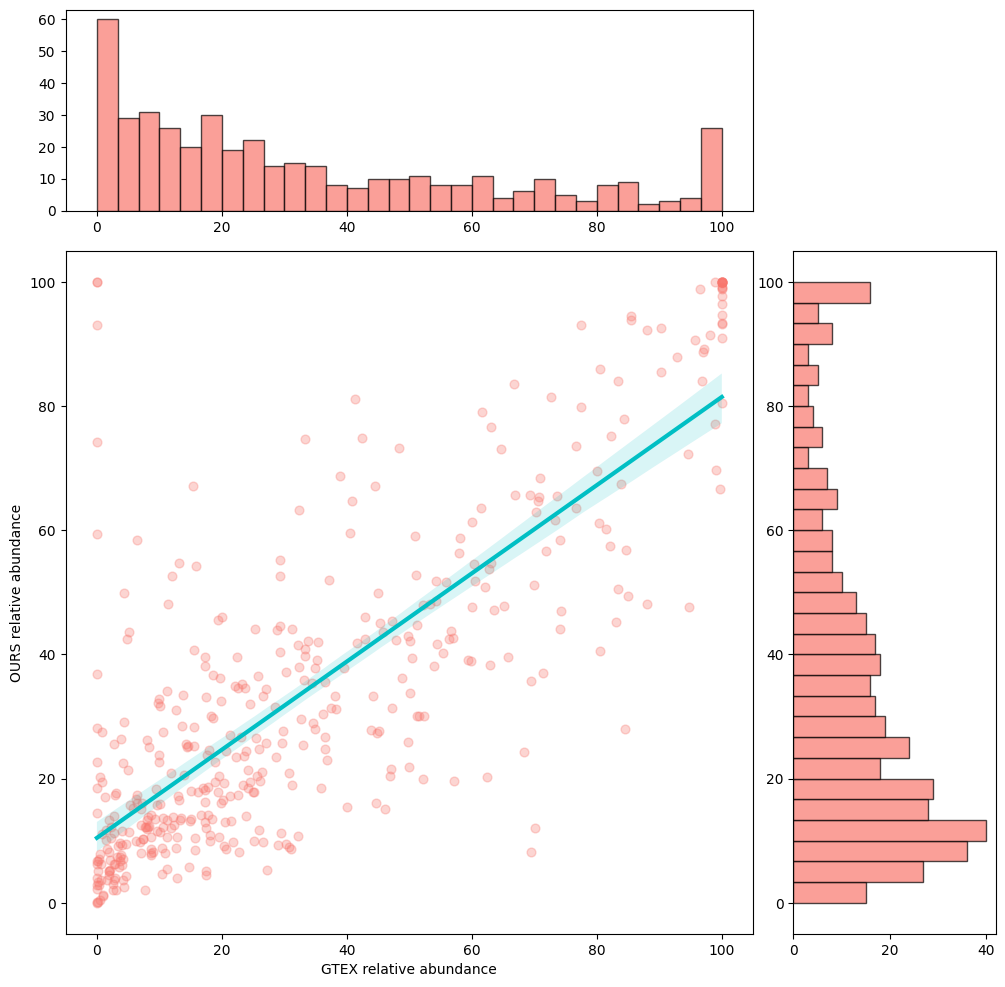

In [38]:
# Create a Seaborn jointplot with KDE (Kernel Density Estimation)
x = df_new_from_known["relative_abundance_percent_GTEX"].copy()
y= df_new_from_known["relative_abundance_percent_OURS"].copy()

# Create the main figure and axes
fig = plt.figure(figsize=(12, 12))
gs = plt.GridSpec(4, 4)

ax_main = fig.add_subplot(gs[1:4, 0:3])
ax_xDist = fig.add_subplot(gs[0, 0:3], sharex=ax_main)
ax_yDist = fig.add_subplot(gs[1:4, 3], sharey=ax_main)

# Scatter plot on main axes
sns.regplot(x=x, y=y, color=ggplot2_colors[0], 
           scatter_kws={"alpha": 0.3, "s":40}, line_kws={"linewidth": 3, "color": ggplot2_colors[4]}, ax=ax_main)

# Histogram on the attached axes
ax_xDist.hist(x, bins=30, edgecolor='k', color=ggplot2_colors[0], alpha=0.7)
ax_yDist.hist(y, bins=30, edgecolor='k', color=ggplot2_colors[0], alpha=0.7, orientation='horizontal')


# Show main axis labels
ax_main.set_xlabel("GTEX relative abundance")
ax_main.set_ylabel("OURS relative abundance")

plt.savefig('../../figures/ours_vs_gtex/DENSITY_new_from_known_transcripts_median_CPM_1_OURS_vs_GTEX_relative_abundance.pdf',
            dpi=600, transparent=True, bbox_inches="tight")

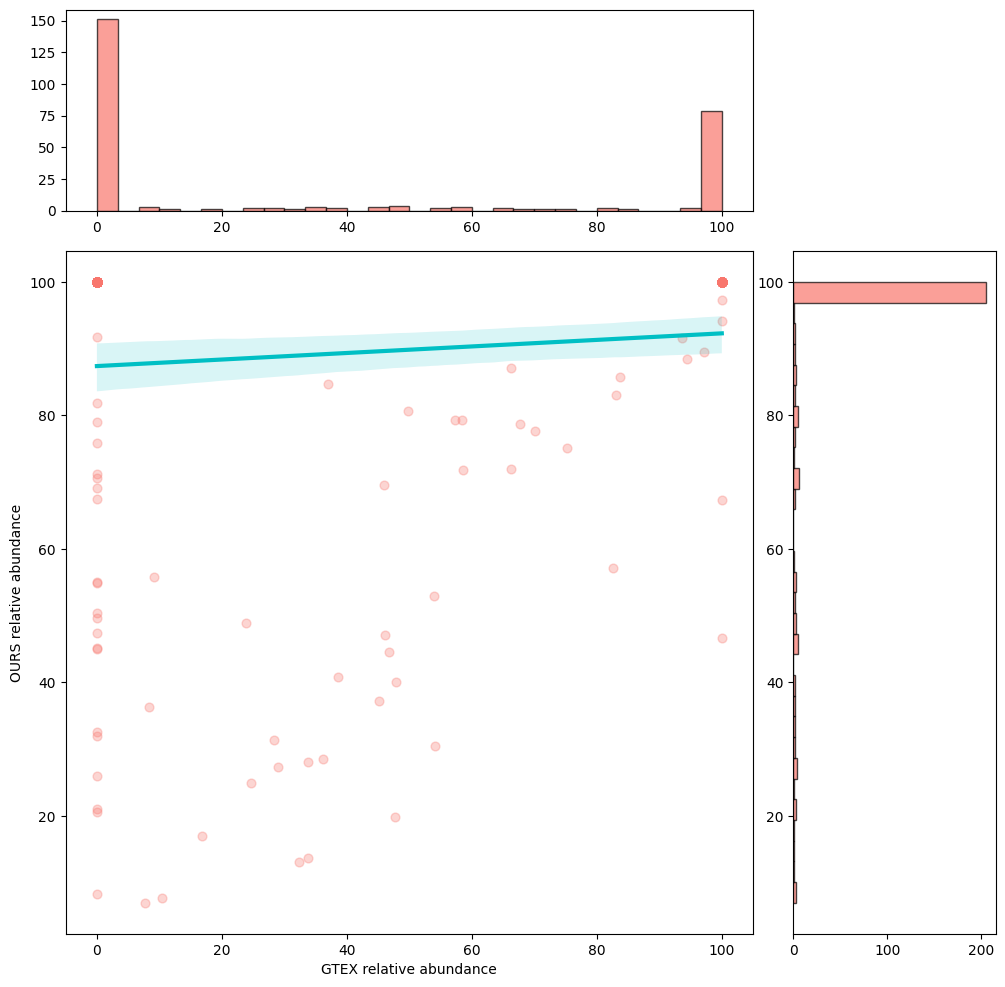

In [39]:
# Create a Seaborn jointplot with KDE (Kernel Density Estimation)
x = df_new_from_new["relative_abundance_percent_GTEX"].copy()
y= df_new_from_new["relative_abundance_percent_OURS"].copy()

# Create the main figure and axes
fig = plt.figure(figsize=(12, 12))
gs = plt.GridSpec(4, 4)

ax_main = fig.add_subplot(gs[1:4, 0:3])
ax_xDist = fig.add_subplot(gs[0, 0:3], sharex=ax_main)
ax_yDist = fig.add_subplot(gs[1:4, 3], sharey=ax_main)

# Scatter plot on main axes
sns.regplot(x=x, y=y, color=ggplot2_colors[0], 
           scatter_kws={"alpha": 0.3, "s":40}, line_kws={"linewidth": 3, "color": ggplot2_colors[4]}, ax=ax_main)

# Histogram on the attached axes
ax_xDist.hist(x, bins=30, edgecolor='k', color=ggplot2_colors[0], alpha=0.7)
ax_yDist.hist(y, bins=30, edgecolor='k', color=ggplot2_colors[0], alpha=0.7, orientation='horizontal')


# Show main axis labels
ax_main.set_xlabel("GTEX relative abundance")
ax_main.set_ylabel("OURS relative abundance")

plt.savefig('../../figures/ours_vs_gtex/DENSITY_new_from_new_transcripts_median_CPM_1_OURS_vs_GTEX_relative_abundance.pdf',
            dpi=600, transparent=True, bbox_inches="tight")

## - Make Figures DensityPlot (median CPM)

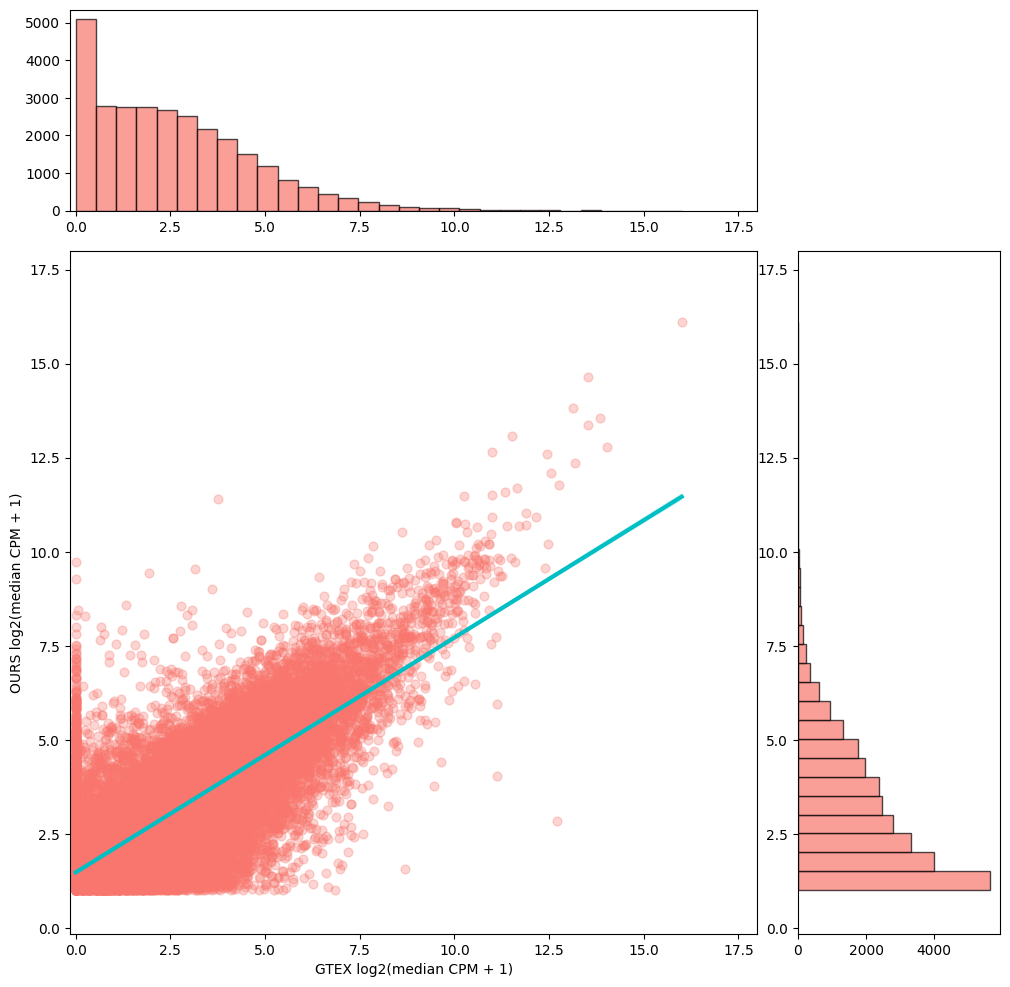

In [40]:
# Create a Seaborn jointplot with KDE (Kernel Density Estimation)
x = df_known["log_plus1_median_CPM_GTEX"].copy()
y= df_known["log_plus1_median_CPM_OURS"].copy()

# Create the main figure and axes
fig = plt.figure(figsize=(12, 12))
gs = plt.GridSpec(4, 4)

ax_main = fig.add_subplot(gs[1:4, 0:3])
ax_xDist = fig.add_subplot(gs[0, 0:3], sharex=ax_main)
ax_yDist = fig.add_subplot(gs[1:4, 3], sharey=ax_main)

# Scatter plot on main axes
sns.regplot(x=x, y=y, color=ggplot2_colors[0], 
           scatter_kws={"alpha": 0.3, "s":40}, line_kws={"linewidth": 3, "color": ggplot2_colors[4]}, ax=ax_main)

# Histogram on the attached axes
ax_xDist.hist(x, bins=30, edgecolor='k', color=ggplot2_colors[0], alpha=0.7)
ax_yDist.hist(y, bins=30, edgecolor='k', color=ggplot2_colors[0], alpha=0.7, orientation='horizontal')


# Show main axis labels
ax_main.set_xlabel("GTEX log2(median CPM + 1)")
ax_main.set_ylabel("OURS log2(median CPM + 1)")

ax_main.set_ylim(-0.15, 18)
ax_main.set_xlim(-0.15, 18)

plt.savefig('../../figures/ours_vs_gtex/DENSITY_known_transcripts_median_CPM_1_OURS_vs_GTEX_log_plus1_median_CPM.pdf',
            dpi=600, transparent=True, bbox_inches="tight")

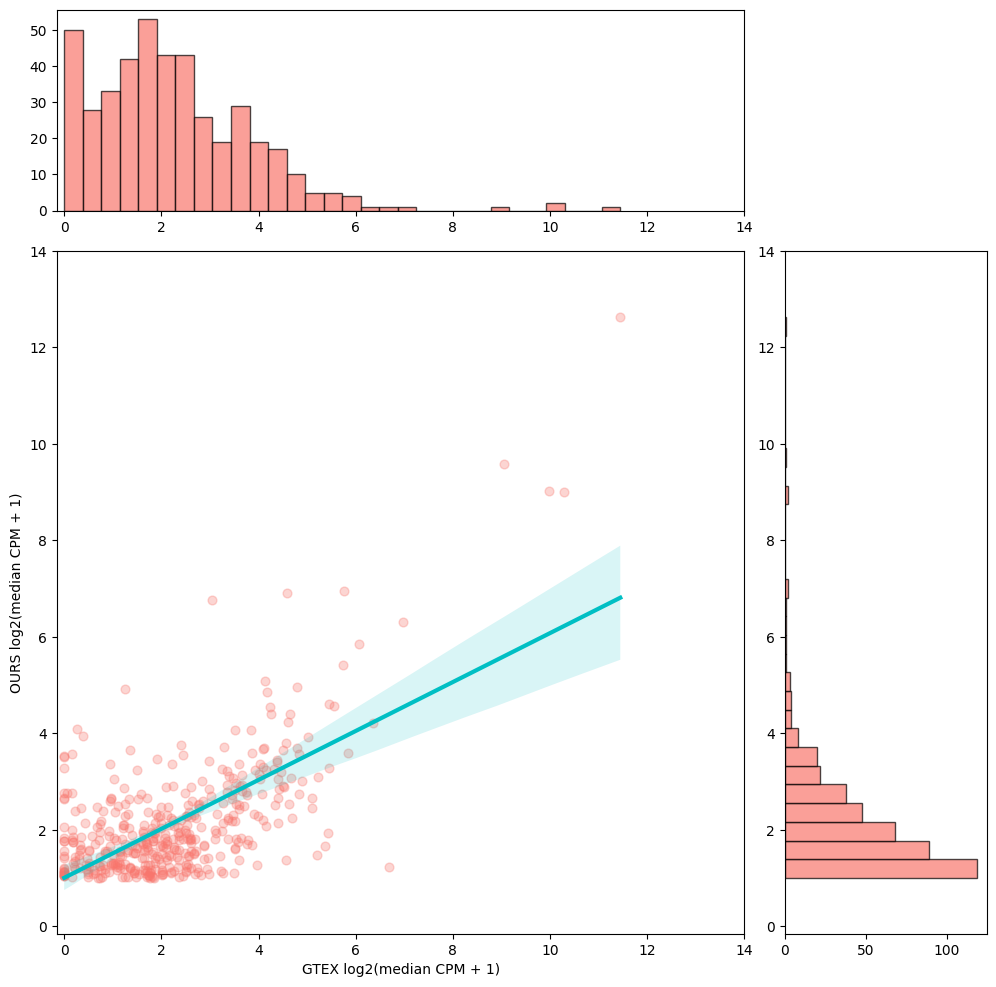

In [41]:
# Create a Seaborn jointplot with KDE (Kernel Density Estimation)
x = df_new_from_known["log_plus1_median_CPM_GTEX"].copy()
y= df_new_from_known["log_plus1_median_CPM_OURS"].copy()

# Create the main figure and axes
fig = plt.figure(figsize=(12, 12))
gs = plt.GridSpec(4, 4)

ax_main = fig.add_subplot(gs[1:4, 0:3])
ax_xDist = fig.add_subplot(gs[0, 0:3], sharex=ax_main)
ax_yDist = fig.add_subplot(gs[1:4, 3], sharey=ax_main)

# Scatter plot on main axes
sns.regplot(x=x, y=y, color=ggplot2_colors[0], 
           scatter_kws={"alpha": 0.3, "s":40}, line_kws={"linewidth": 3, "color": ggplot2_colors[4]}, ax=ax_main)

# Histogram on the attached axes
ax_xDist.hist(x, bins=30, edgecolor='k', color=ggplot2_colors[0], alpha=0.7)
ax_yDist.hist(y, bins=30, edgecolor='k', color=ggplot2_colors[0], alpha=0.7, orientation='horizontal')


# Show main axis labels
ax_main.set_xlabel("GTEX log2(median CPM + 1)")
ax_main.set_ylabel("OURS log2(median CPM + 1)")

ax_main.set_ylim(-0.15, 14)
ax_main.set_xlim(-0.15, 14)

plt.savefig('../../figures/ours_vs_gtex/DENSITY_new_from_known_transcripts_median_CPM_1_OURS_vs_GTEX_log_plus1_median_CPM.pdf',
            dpi=600, transparent=True, bbox_inches="tight")

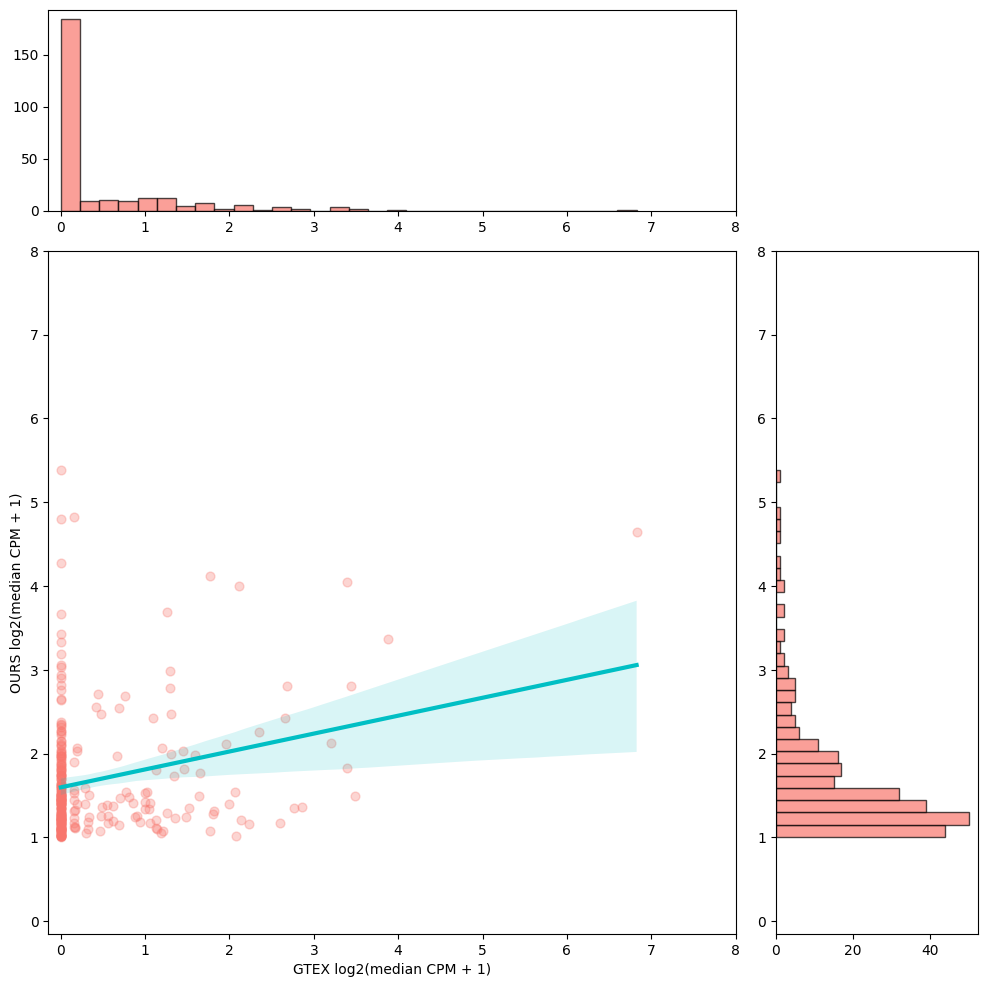

In [42]:
# Create a Seaborn jointplot with KDE (Kernel Density Estimation)
x = df_new_from_new["log_plus1_median_CPM_GTEX"].copy()
y= df_new_from_new["log_plus1_median_CPM_OURS"].copy()

# Create the main figure and axes
fig = plt.figure(figsize=(12, 12))
gs = plt.GridSpec(4, 4)

ax_main = fig.add_subplot(gs[1:4, 0:3])
ax_xDist = fig.add_subplot(gs[0, 0:3], sharex=ax_main)
ax_yDist = fig.add_subplot(gs[1:4, 3], sharey=ax_main)

# Scatter plot on main axes
sns.regplot(x=x, y=y, color=ggplot2_colors[0], 
           scatter_kws={"alpha": 0.3, "s":40}, line_kws={"linewidth": 3, "color": ggplot2_colors[4]}, ax=ax_main)

# Histogram on the attached axes
ax_xDist.hist(x, bins=30, edgecolor='k', color=ggplot2_colors[0], alpha=0.7)
ax_yDist.hist(y, bins=30, edgecolor='k', color=ggplot2_colors[0], alpha=0.7, orientation='horizontal')


# Show main axis labels
ax_main.set_xlabel("GTEX log2(median CPM + 1)")
ax_main.set_ylabel("OURS log2(median CPM + 1)")

ax_main.set_ylim(-0.15, 8)
ax_main.set_xlim(-0.15, 8)

plt.savefig('../../figures/ours_vs_gtex/DENSITY_new_from_new_transcripts_median_CPM_1_OURS_vs_GTEX_log_plus1_median_CPM.pdf',
            dpi=600, transparent=True, bbox_inches="tight")

## - Make figures DensityPlot (total CPM)

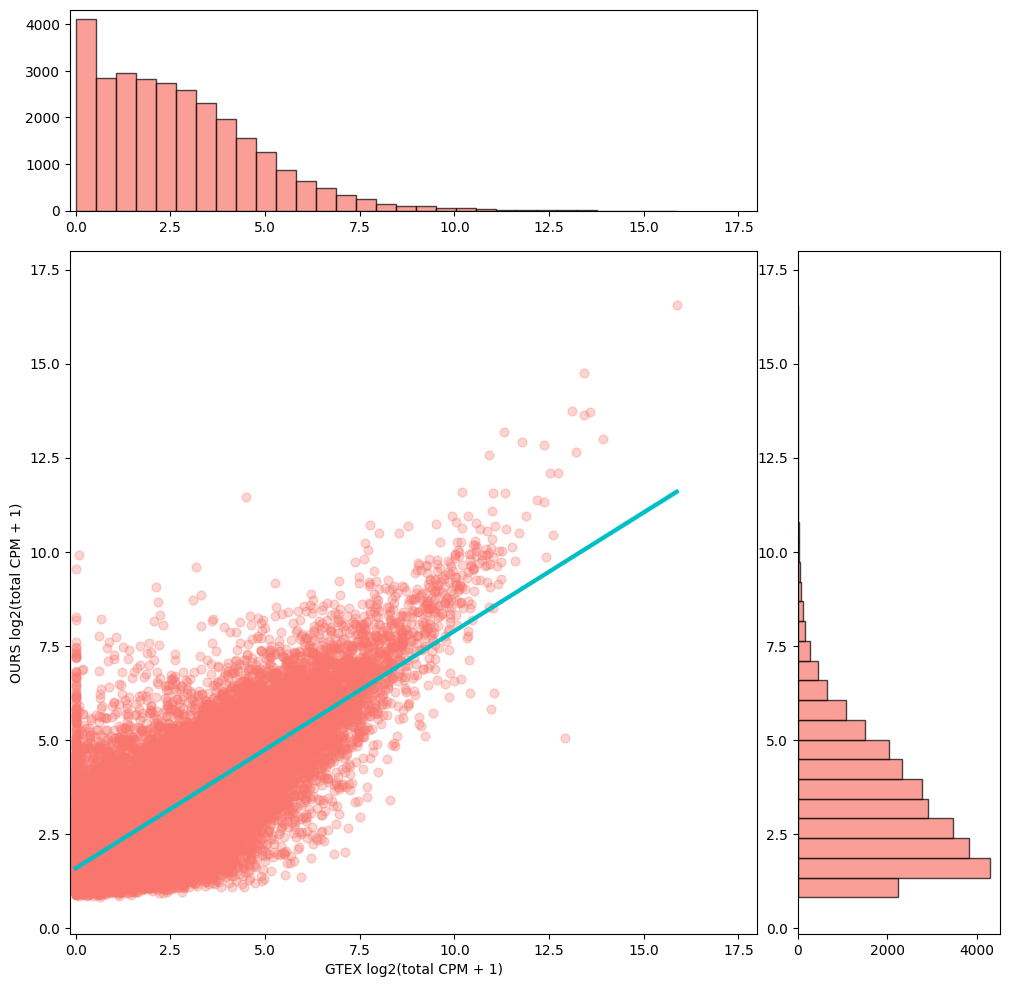

In [43]:
# Create a Seaborn jointplot with KDE (Kernel Density Estimation)
x = df_known["log_plus1_total_CPM_transcript_GTEX"].copy()
y= df_known["log_plus1_total_CPM_transcript_OURS"].copy()

# Create the main figure and axes
fig = plt.figure(figsize=(12, 12))
gs = plt.GridSpec(4, 4)

ax_main = fig.add_subplot(gs[1:4, 0:3])
ax_xDist = fig.add_subplot(gs[0, 0:3], sharex=ax_main)
ax_yDist = fig.add_subplot(gs[1:4, 3], sharey=ax_main)

# Scatter plot on main axes
sns.regplot(x=x, y=y, color=ggplot2_colors[0], 
           scatter_kws={"alpha": 0.3, "s":40}, line_kws={"linewidth": 3, "color": ggplot2_colors[4]}, ax=ax_main)

# Histogram on the attached axes
ax_xDist.hist(x, bins=30, edgecolor='k', color=ggplot2_colors[0], alpha=0.7)
ax_yDist.hist(y, bins=30, edgecolor='k', color=ggplot2_colors[0], alpha=0.7, orientation='horizontal')


# Show main axis labels
ax_main.set_xlabel("GTEX log2(total CPM + 1)")
ax_main.set_ylabel("OURS log2(total CPM + 1)")

ax_main.set_ylim(-0.15, 18)
ax_main.set_xlim(-0.15, 18)

plt.savefig('../../figures/ours_vs_gtex/DENSITY_known_transcripts_median_CPM_1_OURS_vs_GTEX_total_CPM.pdf',
            dpi=600, transparent=True, bbox_inches="tight")

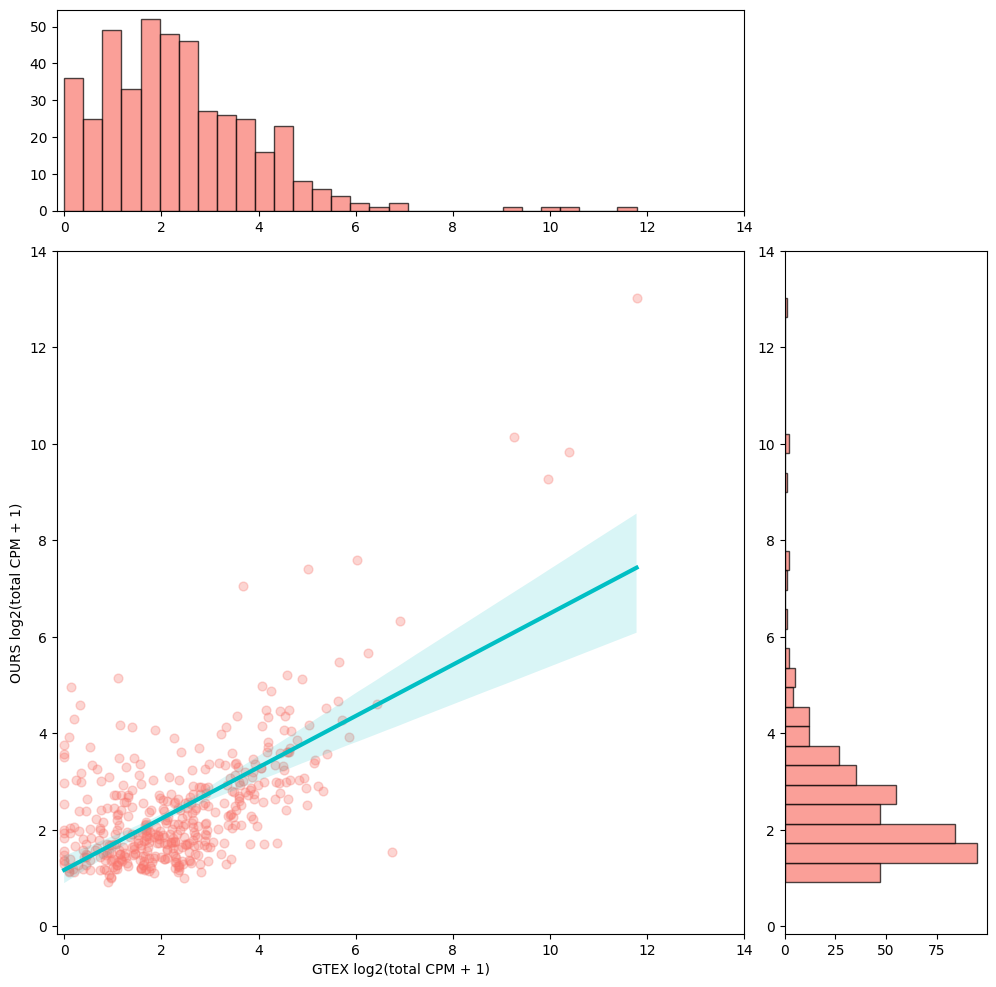

In [44]:
# Create a Seaborn jointplot with KDE (Kernel Density Estimation)
x = df_new_from_known["log_plus1_total_CPM_transcript_GTEX"].copy()
y= df_new_from_known["log_plus1_total_CPM_transcript_OURS"].copy()

# Create the main figure and axes
fig = plt.figure(figsize=(12, 12))
gs = plt.GridSpec(4, 4)

ax_main = fig.add_subplot(gs[1:4, 0:3])
ax_xDist = fig.add_subplot(gs[0, 0:3], sharex=ax_main)
ax_yDist = fig.add_subplot(gs[1:4, 3], sharey=ax_main)

# Scatter plot on main axes
sns.regplot(x=x, y=y, color=ggplot2_colors[0], 
           scatter_kws={"alpha": 0.3, "s":40}, line_kws={"linewidth": 3, "color": ggplot2_colors[4]}, ax=ax_main)

# Histogram on the attached axes
ax_xDist.hist(x, bins=30, edgecolor='k', color=ggplot2_colors[0], alpha=0.7)
ax_yDist.hist(y, bins=30, edgecolor='k', color=ggplot2_colors[0], alpha=0.7, orientation='horizontal')


# Show main axis labels
ax_main.set_xlabel("GTEX log2(total CPM + 1)")
ax_main.set_ylabel("OURS log2(total CPM + 1)")

ax_main.set_ylim(-0.15, 14)
ax_main.set_xlim(-0.15, 14)

plt.savefig('../../figures/ours_vs_gtex/DENSITY_new_from_known_transcripts_median_CPM_1_OURS_vs_GTEX_total_CPM.pdf',
            dpi=600, transparent=True, bbox_inches="tight")

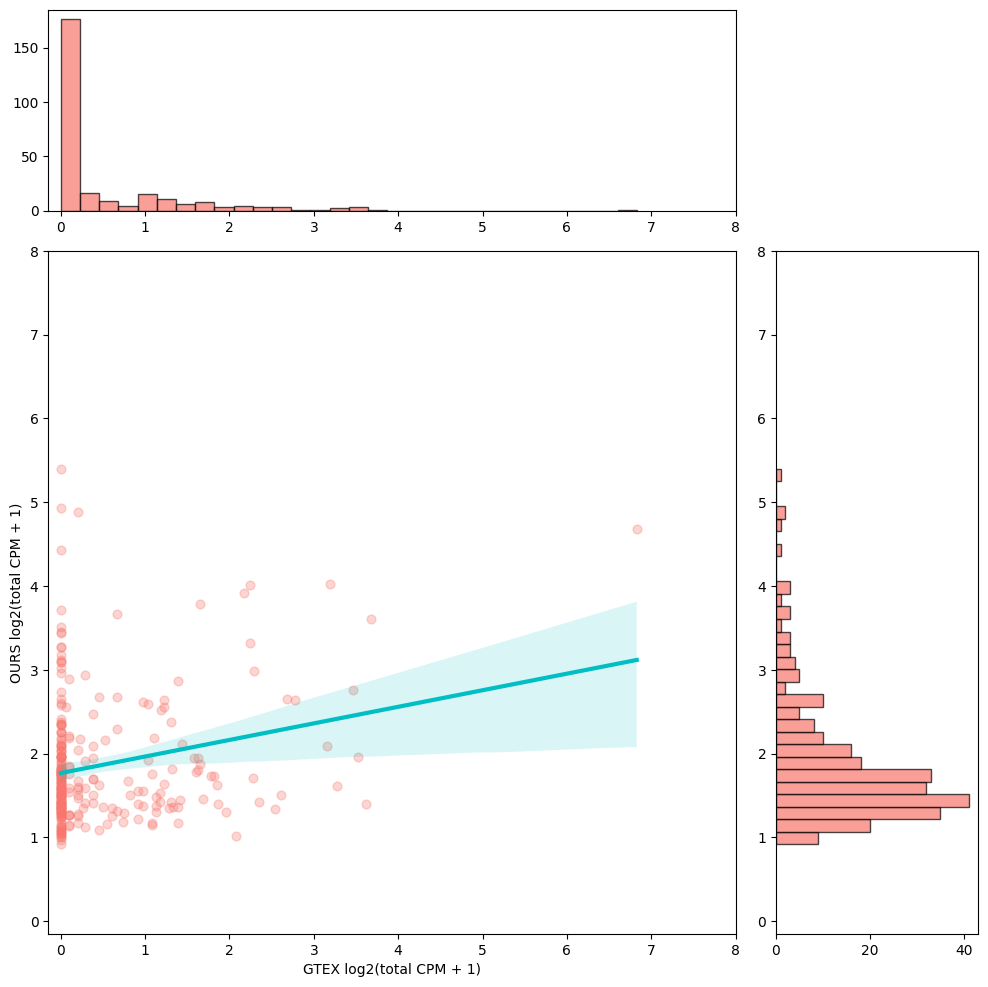

In [45]:
# Create a Seaborn jointplot with KDE (Kernel Density Estimation)
x = df_new_from_new["log_plus1_total_CPM_transcript_GTEX"].copy()
y= df_new_from_new["log_plus1_total_CPM_transcript_OURS"].copy()

# Create the main figure and axes
fig = plt.figure(figsize=(12, 12))
gs = plt.GridSpec(4, 4)

ax_main = fig.add_subplot(gs[1:4, 0:3])
ax_xDist = fig.add_subplot(gs[0, 0:3], sharex=ax_main)
ax_yDist = fig.add_subplot(gs[1:4, 3], sharey=ax_main)

# Scatter plot on main axes
sns.regplot(x=x, y=y, color=ggplot2_colors[0], 
           scatter_kws={"alpha": 0.3, "s":40}, line_kws={"linewidth": 3, "color": ggplot2_colors[4]}, ax=ax_main)

# Histogram on the attached axes
ax_xDist.hist(x, bins=30, edgecolor='k', color=ggplot2_colors[0], alpha=0.7)
ax_yDist.hist(y, bins=30, edgecolor='k', color=ggplot2_colors[0], alpha=0.7, orientation='horizontal')


# Show main axis labels
ax_main.set_xlabel("GTEX log2(total CPM + 1)")
ax_main.set_ylabel("OURS log2(total CPM + 1)")

ax_main.set_ylim(-0.15, 8)
ax_main.set_xlim(-0.15, 8)

plt.savefig('../../figures/ours_vs_gtex/DENSITY_new_from_new_transcripts_median_CPM_1_OURS_vs_GTEX_total_CPM.pdf',
            dpi=600, transparent=True, bbox_inches="tight")

## - Transcripts validated in our data but not in GTEx

In [46]:
## Create list of validated genes in GTEx and our data

list_validated_new_from_known = ["BambuTx1138", "BambuTx1322", "BambuTx1134", "BambuTx1845", "BambuTx1847", "BambuTx1850"]

list_validated_new_from_new= ["BambuTx1025", "BambuTx151", "BambuTx1711", "BambuTx2506", "BambuTx2703", "BambuTx2804"]

In [47]:
## Separate dataframes with genes that validated only in our data versus genes that validated in both

new_from_new_only_OURS = df_new_from_new.loc[((df_new_from_new["total_CPM_transcript_OURS"] > 0) & 
                     (df_new_from_new["total_CPM_transcript_GTEX"] == 0))].copy()

new_from_new_both = df_new_from_new.loc[~((df_new_from_new["total_CPM_transcript_OURS"] > 0) & 
                     (df_new_from_new["total_CPM_transcript_GTEX"] == 0))].copy()

new_from_known_only_OURS = df_new_from_known.loc[((df_new_from_known["total_CPM_transcript_OURS"] > 0) & 
                     (df_new_from_known["total_CPM_transcript_GTEX"] == 0))].copy()

new_from_known_both = df_new_from_known.loc[~((df_new_from_known["total_CPM_transcript_OURS"] > 0) & 
                     (df_new_from_known["total_CPM_transcript_GTEX"] == 0))].copy()

In [48]:
print("New transcripts from new gene bodies only in our data:", new_from_new_only_OURS.shape[0])
print("New transcripts from new gene bodies only in both:", new_from_new_both.shape[0])
print("\n\n")
print("New transcripts from known gene bodies only in our data:", new_from_known_only_OURS.shape[0])
print("New transcripts from known gene bodies only in both:", new_from_known_both.shape[0])

New transcripts from new gene bodies only in our data: 151
New transcripts from new gene bodies only in both: 116



New transcripts from known gene bodies only in our data: 13
New transcripts from known gene bodies only in both: 420


In [49]:
## Make dataframe showing expression of transcripts we have validated

new_from_new_validated = df_new_from_new.loc[df_new_from_new["transcript_id"].isin(list_validated_new_from_new)].copy()

new_from_known_validated = df_new_from_known.loc[df_new_from_known["transcript_id"].isin(list_validated_new_from_known)].copy()

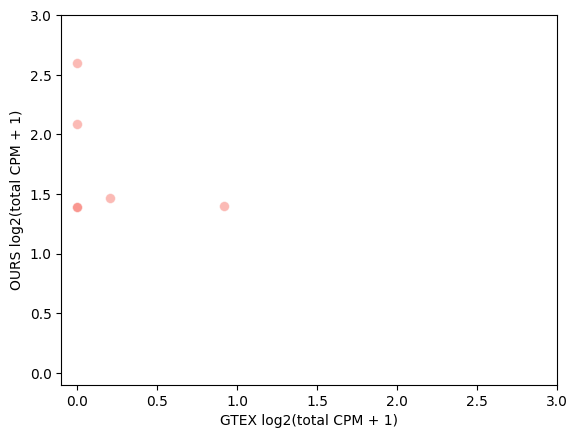

In [50]:
## Scatterplot for new transcripts from new genes that we have validated

sns.scatterplot(data=new_from_new_validated, x="log_plus1_total_CPM_transcript_GTEX", 
                y="log_plus1_total_CPM_transcript_OURS", color=ggplot2_colors[0], s=50, legend=False, alpha=0.5)

plt.xlabel("GTEX log2(total CPM + 1)")
plt.ylabel("OURS log2(total CPM + 1)")

plt.ylim(-0.1, 3)
plt.xlim(-0.1, 3)


plt.savefig('../../figures/ours_vs_gtex/VALIDATED_new_from_new_transcripts_median_CPM_1_OURS_vs_GTEX_total_CPM.pdf',
            dpi=600, transparent=True, bbox_inches="tight")

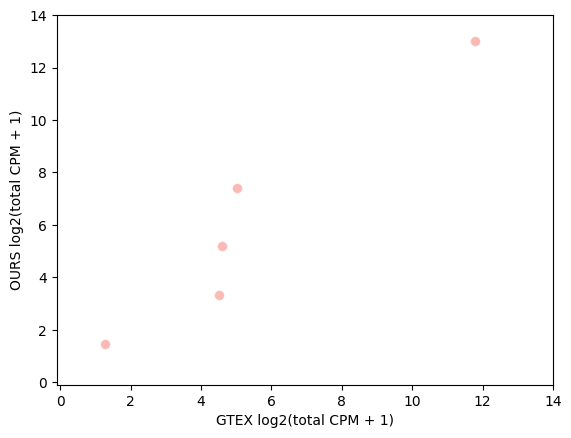

In [51]:
## Scatterplot for new transcripts from known genes that we have validated (including mito)

sns.scatterplot(data=new_from_known_validated, x="log_plus1_total_CPM_transcript_GTEX", 
                y="log_plus1_total_CPM_transcript_OURS", color=ggplot2_colors[0], s=50, legend=False, alpha=0.5)

plt.xlabel("GTEX log2(total CPM + 1)")
plt.ylabel("OURS log2(total CPM + 1)")

plt.ylim(-0.1, 14)
plt.xlim(-0.1, 14)

plt.savefig('../../figures/ours_vs_gtex/VALIDATED_new_from_known_transcripts_median_CPM_1_OURS_vs_GTEX_total_CPM.pdf',
            dpi=600, transparent=True, bbox_inches="tight")

## - Unique and full-length counts analysis

In [52]:
## Import data for unique and full-length transcript level counts and fix column names

df_gtex_unique = pd.read_csv("../../data/raw/rebuttal_data/GTEX_with_our_extended_annotation_quant/bambu_quant/uniqueCounts_transcript.txt", 
                           delimiter="\t", low_memory=False, header=0)

df_gtex_full = pd.read_csv("../../data/raw/rebuttal_data/GTEX_with_our_extended_annotation_quant/bambu_quant/fullLengthCounts_transcript.txt", 
                           delimiter="\t", low_memory=False, header=0)

## Only keep BA9 brain samples
## Excluded BA9 sample "GTEX-T5JC-0011-R10A-SM-2TT23.FAK91589" because it had only 46331 reads.
df_gtex_unique = df_gtex_unique[["TXNAME", "GENEID","GTEX-1192X-0011-R10a-SM-4RXXZ.FAK49046_mapped_filtered_sorted",
                  "GTEX-13X6J-0011-R10b-SM-5CEKT.FAK44896_mapped_filtered_sorted",
                  "GTEX-14BIL-0011-R10a-SM-5EQV4.FAK49209_mapped_filtered_sorted",
                  "GTEX-QDT8-0011-R10A-SM-2FKJB.FAK49182_mapped_filtered_sorted"]]

df_gtex_full = df_gtex_full[["TXNAME", "GENEID","GTEX-1192X-0011-R10a-SM-4RXXZ.FAK49046_mapped_filtered_sorted",
                  "GTEX-13X6J-0011-R10b-SM-5CEKT.FAK44896_mapped_filtered_sorted",
                  "GTEX-14BIL-0011-R10a-SM-5EQV4.FAK49209_mapped_filtered_sorted",
                  "GTEX-QDT8-0011-R10A-SM-2FKJB.FAK49182_mapped_filtered_sorted"]]


df_gtex_unique = fix_column_names(df_gtex_unique, is_gene=False)

df_gtex_full = fix_column_names(df_gtex_full, is_gene=False)

In [53]:
## Calculate total counts
df_gtex_unique["total_counts"] = df_gtex_unique[df_gtex_unique.filter(regex='count').columns].sum(axis=1)

df_gtex_full["total_counts"] = df_gtex_full[df_gtex_full.filter(regex='count').columns].sum(axis=1)

## Calculate log2(total_counts + 1)
df_gtex_unique["log_plus1_total_counts"] = np.log2((df_gtex_unique['total_counts'] + 1))

df_gtex_full["log_plus1_total_counts"] = np.log2((df_gtex_full['total_counts'] + 1))

## Add identifier columns
df_gtex_unique["counts_type"] = "Unique counts"

df_gtex_full["counts_type"] = "Full-length counts"


## Reduce datasets to important columns
df_gtex_unique = df_gtex_unique[["gene_id", "transcript_id", "log_plus1_total_counts", "counts_type"]].copy()

df_gtex_full = df_gtex_full[["gene_id", "transcript_id", "log_plus1_total_counts", "counts_type"]].copy()

## Concatenate datasets
df_gtex_full_unique = pd.concat([df_gtex_unique, df_gtex_full])

In [54]:
## Create variable to identify transcript discovery type (new_from_known VS new_from_new)

mask = df_gtex_full_unique["transcript_id"].isin(df_new_from_new['transcript_id'])
df_gtex_full_unique.loc[mask, "transcript_type"] = "New transcripts from\nnew gene bodies"


mask = df_gtex_full_unique["transcript_id"].isin(df_new_from_known['transcript_id'])
df_gtex_full_unique.loc[mask, "transcript_type"] = "New transcripts from\nknown gene bodies"

df_gtex_full_unique.dropna(inplace=True)

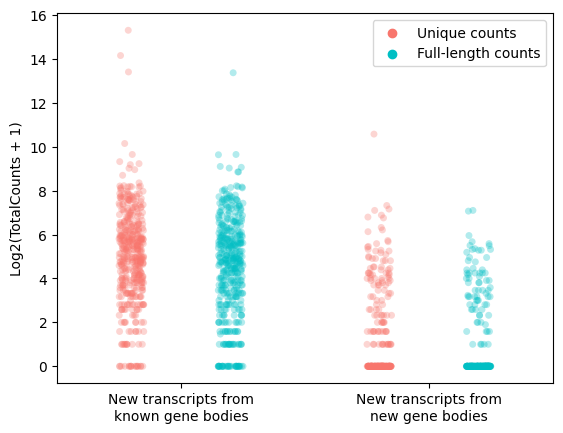

In [55]:
## Create stripplot looking at number of full-length and unique reads for new high-confidence transcripts in GTEx data
sns.stripplot(df_gtex_full_unique, x="transcript_type", y="log_plus1_total_counts", hue="counts_type",
              alpha=0.3, palette=[ggplot2_colors[0], ggplot2_colors[4]], s=5, dodge=True)

plt.ylabel("Log2(TotalCounts + 1)")
plt.xlabel(None)

plt.legend(loc="upper right")

plt.savefig('../../figures/ours_vs_gtex/GTEX_new_transcripts_unique_and_full_length_counts_boxplot.pdf',
            dpi=600, transparent=True, bbox_inches="tight")

In [56]:
## Separate new from new and new from known

df_gtex_full_unique_nfn = df_gtex_full_unique.loc[df_gtex_full_unique["transcript_type"] 
                                           == "New transcripts from\nnew gene bodies"].copy()

df_gtex_full_unique_nfk = df_gtex_full_unique.loc[df_gtex_full_unique["transcript_type"] 
                                           == "New transcripts from\nknown gene bodies"].copy()

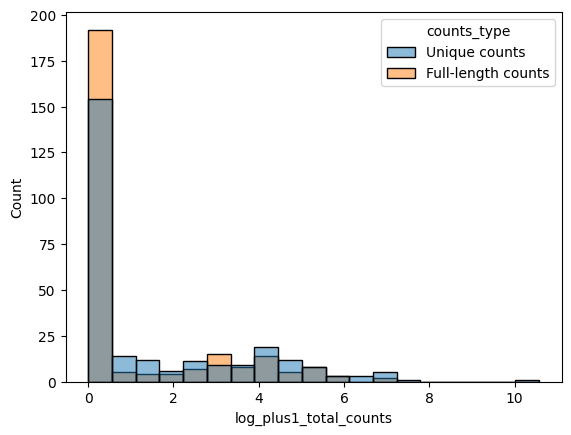

In [57]:
## Histogram new from new unique counts and full-length counts

sns.histplot(df_gtex_full_unique_nfn, x="log_plus1_total_counts", hue="counts_type")

plt.savefig('../../figures/ours_vs_gtex/GTEX_new_from_new_unique_and_full_length_counts_histogram.pdf',
            dpi=600, transparent=True, bbox_inches="tight")

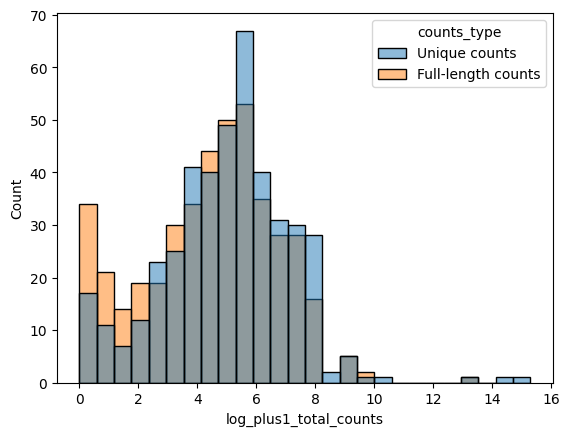

In [58]:
## Histogram new from known unique counts and full-length counts

sns.histplot(df_gtex_full_unique_nfk, x="log_plus1_total_counts", hue="counts_type")


plt.savefig('../../figures/ours_vs_gtex/GTEX_new_from_known_unique_and_full_length_counts_histogram.pdf',
            dpi=600, transparent=True, bbox_inches="tight")

## - Save transcripts for validation

In [60]:
## Save nfn only in our data (all counts)
new_from_new_only_OURS_out = new_from_new_only_OURS[['transcript_id', 'gene_id', 'chr', 'median_CPM_GTEX', 
                                                     "median_CPM_OURS", "median_CPM_GTEX",
                                                    'total_CPM_transcript_GTEX', "total_CPM_transcript_OURS"]].copy()

new_from_new_only_OURS_out.to_csv("../../data/processed/ours_vs_gtex/new_from_new_all_counts_only_OURS_not_GTEx.tsv",
                                 sep="\t", index=False)

In [61]:
## Save nfn only in our data (all counts)
new_from_new_both_out = new_from_known_both[['transcript_id', 'gene_id', 'chr', 'median_CPM_GTEX', 
                                                     "median_CPM_OURS", "median_CPM_GTEX",
                                                    'total_CPM_transcript_GTEX', "total_CPM_transcript_OURS"]].copy()

new_from_new_both_out.to_csv("../../data/processed/ours_vs_gtex/new_from_new_all_counts_both.tsv",
                                 sep="\t", index=False)

In [62]:
## Save nfn only in our data (all counts)
new_from_known_only_OURS_out = new_from_known_only_OURS[['transcript_id', 'gene_id', 'chr', 'median_CPM_GTEX', 
                                                     "median_CPM_OURS", "median_CPM_GTEX",
                                                    'total_CPM_transcript_GTEX', "total_CPM_transcript_OURS"]].copy()

new_from_known_only_OURS_out.to_csv("../../data/processed/ours_vs_gtex/new_from_known_all_counts_only_OURS_not_GTEx.tsv",
                                 sep="\t", index=False)

In [63]:
## Save nfn only in our data (all counts)
new_from_known_both_out = new_from_known_both[['transcript_id', 'gene_id', 'chr', 'median_CPM_GTEX', 
                                                     "median_CPM_OURS", "median_CPM_GTEX",
                                                    'total_CPM_transcript_GTEX', "total_CPM_transcript_OURS"]].copy()

new_from_known_both_out.to_csv("../../data/processed/ours_vs_gtex/new_from_known_all_counts_both.tsv",
                                 sep="\t", index=False)

In [64]:
## Save full and unique counts for new from new and new from known transcripts

df_gtex_full_unique_nfn.to_csv("../../data/processed/ours_vs_gtex/new_from_new_full_and_unique_counts.tsv",
                              sep="\t", index=False)

df_gtex_full_unique_nfk.to_csv("../../data/processed/ours_vs_gtex/new_from_known_full_and_unique_counts.tsv",
                              sep="\t", index=False)